In [1]:
%matplotlib inline



Basic tutorial: quantum teleportation
=====================================

>"A trick that quantum magicians use to produce phenomena that cannot be imitated by classical magicians." -  A. Peres [1].

To see how to construct and simulate a simple continuous-variable (CV) quantum circuit in Strawberry
Fields, let's consider the case of **state teleportation**.

Background theory
-----------------

Quantum teleportation - sometimes referred to as state teleportation to avoid confusion
with gate teleportation - is the reliable transfer of an unknown quantum state across
spatially separated qubits or qumodes, through the use of a classical transmission channel
and quantum entanglement [2]. Considered a fundamental quantum information
protocol, it has applications ranging from quantum communication to enabling distributed
information processing in quantum computation [3].

In general, all quantum teleportation circuits work on the same basic principle. Two
distant observers, Alice and Bob, share a maximally entangled quantum state (in discrete
variables, any one of the four [Bell states](https://en.wikipedia.org/wiki/Bell_state);
or in CV, a maximally entangled state for a fixed energy), and have access to a classical
communication channel. Alice, in possession of an unknown state which she wishes to
transport to Bob, makes a joint measurement of the unknown state and her half of the
entangled state, by projecting onto the Bell basis. By transmitting the results of her
measurement to Bob, Bob is then able to transform his half of the entangled state to
an accurate replica of the original unknown state, by performing a conditional phase
flip (for qubits) or displacement (for qumodes) [4].

While originally designed for discrete-variable quantum computation with qubits, the
(spatially separated) quantum teleportation algorithm described above can be easily
translated to CV qumodes; the result is shown in the following circuit:

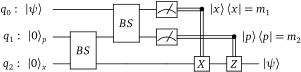

This process can be explained as follows:

1. Here, qumodes $q_1$ and $q_2$ are initially prepared as (the unphysical)
   infinitely squeezed vacuum states in momentum and position space respectively,

$$
\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}
\begin{align*}
   &\ket{0}_x \sim \lim_{z\rightarrow\infty} S(z)\ket{0} \\ 
   &\ket{0}_p \sim \lim_{z\rightarrow-\infty} S(z)\ket{0}=\frac{1}{\sqrt{\pi}}\int_{-\infty}^\infty \ket{x}~dx
\end{align*}
$$

   before being maximally entangled by a 50-50 beamsplitter:

$$
BS(\pi/4,0)(\ket{0}_p\otimes\ket{0}_x)
$$

2. These two qumodes are now spatially separated, with $\ket{q_1}$ held by
   Alice, and $\ket{q_2}$ held by Bob, with the two connected via the classical
   communication channels $c_0$ and $c_1$.


3. To teleport her unknown state $\ket{\psi}$ to Bob, Alice now performs a projective
   measurement of her entire system onto the maximally entangled basis states. This is done
   by entangling $\ket{\psi}$ and $\ket{q_1}$ via another 50-50 beamsplitter,
   before performing two homodyne measurements, in the $x$ and $p$ quadratures respectively.


4. The results of these measurements are then transmitted to Bob, who performs both a
   position displacement (conditional on the $x$ measurement) and a momentum
   displacement (conditional on the $p$ measurement) to recover exactly the
   transmitted state $\ket{\psi}$.


Importing Strawberry Fields
---------------------------

The first thing we need to do is import Strawberry Fields; we do this with the following import
statements:


In [2]:
import strawberryfields as sf
from strawberryfields.ops import *

import numpy as np
from numpy import pi, sqrt

# set the random seed
np.random.seed(42)

The first import statement imports Strawberry Fields as ``sf``, allowing us to access the engine
and backends; the second import statement imports all available CV gates into the global
namespace. Finally, we import $\pi$ and the square root from ``NumPy`` so that we can pass angle
parameters to gates such as beamsplitters, and perform some custom classical processing.

Program initialization
----------------------

We can now initialize our quantum program by instantiating a [``Program``](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.Program.html) class:

``sf.Program(num_subsystems, name=None)``

where

* ``num_subsystems`` (*int*) is the number of modes we want to initialize in our quantum register
* ``name`` (*str*) is the name of the program (optional)

> **Note:** By default, Strawberry Fields uses the convention $\hbar=2$ for the commutation relation $[\hat{x},\hat{p}]=i\hbar$. Other conventions can also be chosen by setting the global variable ``sf.hbar`` at the beginning of a session.
The value of $\hbar$ chosen modifies the application of the [``Xgate``](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.ops.Xgate.html) and [``Zgate``](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.ops.Zgate.html), as well as the
measurements returned by Homodyne measurement [``MeasureHomodyne``](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.ops.MeasureHomodyne.html), so this must be taken into account if the value of $\hbar$ is modified. All other gates are
unaffected. See [Conventions and formulas](https://strawberryfields.ai/photonics/conventions/index.html#conventions) for more details.

Therefore, to initialize a program on three quantum registers, we write:



In [3]:
prog = sf.Program(3)

Circuit construction
--------------------

To prepare states and apply gates to the quantum register ``q``, we must be inside the context of
the program we initialized using the ``with`` statement. Everything within the program context is
written using the [Blackbird quantum programming language](https://strawberryfields.ai/photonics/demos/run_blackbird.html#blackbird). For example, to
construct the following state teleportation circuit

![](teleport.png)

to teleport the coherent state $\ket{\alpha}$ where $\alpha=1+0.5i$:



In [4]:
alpha = 1+0.5j
r = np.abs(alpha)
phi = np.angle(alpha)

with prog.context as q:
    # prepare initial states
    Coherent(r, phi) | q[0]
    Squeezed(-2) | q[1]
    Squeezed(2) | q[2]

    # apply gates
    BS = BSgate(pi/4, pi)
    BS | (q[1], q[2])
    BS | (q[0], q[1])

    # Perform homodyne measurements
    MeasureX | q[0]
    MeasureP | q[1]

    # Displacement gates conditioned on
    # the measurements
    Xgate(sqrt(2) * q[0].par) | q[2]
    Zgate(-sqrt(2) * q[1].par) | q[2]

A couple of things to note here:

- **The quantum register returned from the** ``prog.context`` **context manager is a sequence**.
  Individual modes can be accessed via standard Python indexing and slicing techniques.

- **Preparing initial states, measurements, and gate operations all make use of the following
  syntax:**

  ``Operation([arg1, arg2, ...]) | reg``

  where the number of arguments depends on the specific operation, and ``reg`` is either a
  single mode or a sequence of modes, depending on how many modes the operation acts on. For a full
  list of operations and gates available, see the [quantum gates](https://strawberryfields.readthedocs.io/en/stable/code/sf_ops.html#gates) documentation.

- **Every time a operation is applied it is added to the command queue**, ready to be simulated by
  the backend.

- **Operations must be applied in temporal order**. Different operation orderings can result in the
  same quantum circuit, providing the operations do not apply sequentially to the same mode. For
  example, we can permute the line containing ``MeasureX`` and ``MeasureP`` without changing the
  result.

- **Gates are standard Python objects, and can be treated as such**. In this case, since both
  beamsplitters use the same parameters, a single instance is being instantiated and stored under
  variable ``BS``.

- **The results of measured modes are passed to gates simply by passing the measured mode as an
  argument.** In order to perform additional classical processing to the measured mode ``q[i]``, and
  use the result to control a subsequent quantum operation, we can use the ``q[i].par`` attribute
  within the operation argument.

> **Note:** By choosing a different phase for the 50-50 beamsplitter, that is, ``BSgate(pi/4,0)``, we can avoid having to negate the [``Zgate``](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.ops.Zgate.html) correction at the end of the circuit.

Executing the program
---------------------

Once the program is constructed, we then must initialize an **engine**, which is responsible for
executing the program on a specified **backend** (which can be either a local simulator, or a
remote simulator/hardware device). Engines are initialized as follows:

``sf.Engine(backend, backend_options={})``

where

- ``backend``: a string or [``BaseBackend``](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.backends.BaseBackend.html) object representing the Strawberry Fields backend we wish to use; we have the choice of two Fock backends [5], the NumPy based (``'fock'``) and TensorFlow (``'tf'``), and one Gaussian backend [6] (``'gaussian'``).

  This argument is *required* when creating the engine.

- ``backend_options`` is a dictionary containing options specific to the chosen backend.

Let's choose the Fock backend for this particular example. Since we are working in the Fock basis,
we must also specify the Fock basis *cutoff dimension*; let's choose ``cutoff_dim=15``, such that
a state $\ket{\psi}$ has approximation

$$
\ket{\psi} = \sum_{n=0}^\infty c_n\ket{n} \approx \sum_{n=0}^{\texttt{cutoff}\_\texttt{dim}-1} c_n\ket{n}
$$

in our truncated Fock basis. We now have all the parameters ready to initialize the engine:



In [5]:
eng = sf.Engine('fock', backend_options={"cutoff_dim": 15})

> **Warning:** To avoid significant numerical error when working with the Fock backend, we need to make sure from now on that all initial states and gates we apply result in negligible amplitude in the Fock basis for Fock states $\ket{n}, ~~n\geq \texttt{cutoff}\_\texttt{dim}$. For example, to prepare a squeezed vacuum state in the $x$ quadrature with ``cutoff_dim=10``, a     squeezing factor of $r=1$ provides an acceptable approximation, since $|\langle n \vert z \rangle|^2 < 0.02$ for $n\geq 10$.

We can now execute our quantum program ``prog`` on the engine via the [``run()``](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.Engine.html#strawberryfields.Engine.run):



In [6]:
result = eng.run(prog, shots=1, modes=None, compile_options={})

The [``eng.run``](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.Engine.html#strawberryfields.Engine.run) method accepts the arguments:

* ``program``: The [``Program``](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.Program.html) to execute.

* ``shots``: A positive integer that specifies the number of times the program measurement
  evaluation is to be repeated.

* ``modes``: An optional list of integers that specifies which modes we wish the backend to
  return for the quantum state. If the state is a mixed state represented by a density matrix,
  then the backend will automatically perform a partial trace to return only the modes
  specified. Note that this only affects the returned state object---all modes remain in the
  backend circuit.

* ``compile_options``: A dictionary of keyword arguments to be used for program compilation. To
  ensure the ``~strawberryfields.Program`` will run on the specified backend, the engine will
  perform **program compilation**, by calling the [``compile()``](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.Program.html#strawberryfields.Program.compile) method.

> **Note:** A ``shots`` value different than 1 is currently only supported for one specific case: the ``MeasureFock/Measure`` operation executed on the Gaussian backend.

Other useful engine methods that can be called at any time include:

* [``eng.print_applied()``](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.engine.BaseEngine.html#strawberryfields.engine.BaseEngine.print_applied): Prints all commands applied using [``eng.run``](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.engine.LocalEngine.html#strawberryfields.engine.LocalEngine.run) since the last backend reset/initialisation.

  - This may differ from your original constructed program due to program compilation. As a
    result, this shows all applied gate decompositions, which may differ depending on the backend.

* [``eng.reset()``](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.engine.BaseEngine.html#strawberryfields.engine.BaseEngine.reset): Resets the backend circuit to the vacuum state.

Results and visualization
-------------------------

The returned [``Result``](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.Result.html) object provides several useful properties for accessing the results of your program execution:

* ``result.state``: The quantum state object contains details and methods for manipulation of the
  final circuit state.

  Note that only local simulators will return a state object. Remote simulators and hardware
  backends will return measurement [``sample``](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.Result.html#strawberryfields.Result.samples), but the return value of ``state`` will be ``None``.

  Depending on backend used, the state returned might be a [``BaseFockState``](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.backends.BaseFockState.html), which represents the state using the
  Fock/number basis, or might be a [``BaseGaussianState``](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.backends.BaseGaussianState.html), which represents the state using Gaussian representation, as a vector of means and a covariance
  matrix. Many methods are provided for state manipulation, see [States](https://strawberryfields.readthedocs.io/en/stable/introduction/states.html) for more details.

* ``result.samples``: Measurement samples from any measurements performed. Returned measurement
  samples will have shape ``(shots, modes)``.

Once the engine has been run, we can extract results of measurements and the quantum state from
the circuit. Any measurements performed on a mode are stored attribute [``result.samples``](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.Result.html#strawberryfields.Result.samples):



In [7]:
print(result.samples)

[[0.19890199 0.17330173]]


If a mode has not been measured, this attribute simply returns ``None``.

In this particular example, we are using the Fock backend, and so the state that was returned by
``result.state`` is in the Fock basis. To double check this, we can inspect it with the ``print``
function:



In [8]:
print(result.state)
state = result.state

<FockState: num_modes=3, cutoff=15, pure=False, hbar=2>


In addition to the parameters we have already configured when creating and running the engine, the
line ``pure=False``, indicates that this is a mixed state represented as a density matrix, and not
a state vector.

To return the density matrix representing the Fock state, we can use the method [``state.dm``](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.backends.BaseFockState.html#strawberryfields.backends.BaseFockState.dm) [7]. In this case, the density matrix has dimension



In [9]:
print(state.dm().shape)

(15, 15, 15, 15, 15, 15)


Here, we use the convention that every pair of consecutive dimensions corresponds to a subsystem;
i.e.,

$$
\rho_{\underbrace{ij}_{q[0]}~\underbrace{kl}_{q[1]}~\underbrace{mn}_{q[2]}}
$$

Thus we can calculate the reduced density matrix for mode ``q[2]``, $\rho_2$:



In [10]:
rho2 = np.einsum('kkllij->ij', state.dm())
print(rho2.shape)

(15, 15)


> **Note:** The Fock state also provides the method [``reduced_dm()``](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.backends.BaseFockState.html#strawberryfields.backends.BaseFockState.reduced_dm) for extracting the reduced density matrix automatically.

The diagonal values of the reduced density matrix contain the marginal Fock state probabilities
$|\langle i \vert \rho_2 \rangle|^2,~~ 0\leq i\leq 14$:



In [11]:
probs = np.real_if_close(np.diagonal(rho2))
print(probs)

[3.10694907e-01 3.62467630e-01 2.11807608e-01 8.23802050e-02
 2.43874177e-02 5.83556629e-03 1.26776314e-03 2.37656289e-04
 8.43934922e-05 1.78787082e-06 1.52342119e-04 1.07036413e-05
 3.36055927e-04 1.47426072e-05 1.92773805e-04]


We can then use a package such as matplotlib to plot the marginal Fock state probability
distributions for the first 6 Fock states, for the teleported mode ``q[2]``:



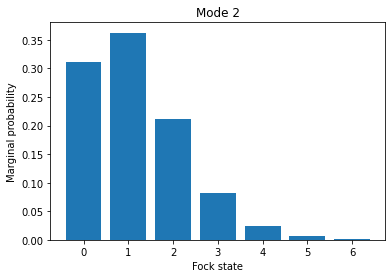

In [12]:
from matplotlib import pyplot as plt
plt.bar(range(7), probs[:7])
plt.xlabel('Fock state')
plt.ylabel('Marginal probability')
plt.title('Mode 2')
plt.show()

Note that this information can also be extracted automatically via the Fock state method [``all_fock_probs()``](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.backends.BaseFockState.html#strawberryfields.backends.BaseFockState.all_fock_probs):



In [13]:
fock_probs = state.all_fock_probs()
fock_probs.shape
print(np.sum(fock_probs, axis=(0,1)))

[3.10694907e-01 3.62467630e-01 2.11807608e-01 8.23802050e-02
 2.43874177e-02 5.83556629e-03 1.26776314e-03 2.37656289e-04
 8.43934922e-05 1.78787082e-06 1.52342119e-04 1.07036413e-05
 3.36055927e-04 1.47426072e-05 1.92773805e-04]


Full program
------------

The full Strawberry Fields program for teleportation is given by:

```
    import strawberryfields as sf
    from strawberryfields.ops import *

    import numpy as np
    from numpy import pi, sqrt

    prog = sf.Program(3)

    alpha = 1+0.5j
    r = np.abs(alpha)
    phi = np.angle(alpha)

    with prog.context as q:
        # prepare initial states
        Coherent(r, phi) | q[0]
        Squeezed(-2) | q[1]
        Squeezed(2) | q[2]

        # apply gates
        BS = BSgate(pi/4, pi)
        BS | (q[1], q[2])
        BS | (q[0], q[1])

        # Perform homodyne measurements
        MeasureX | q[0]
        MeasureP | q[1]

        # Displacement gates conditioned on
        # the measurements
        Xgate(sqrt(2) * q[0].par) | q[2]
        Zgate(sqrt(2) * q[1].par) | q[2]

    eng = sf.Engine('fock', backend_options={'cutoff_dim': 15})
    result = eng.run(prog, shots=1, modes=None, compile_options={})
```



Footnotes
---------

[5] Fock backends are backends which represent the quantum state and operations via the Fock basis. These can represent *all* possible CV states and operations, but also introduce numerical error due to truncation of the Fock space, and consume more memory.

[6] The Gaussian backend, due to its ability to represent states and operations as Gaussian
       objects/transforms in the phase space, consumes less memory and is less computationally intensive
       then the Fock backends. However, it cannot represent non-Gaussian operations and states (such as
       the cubic phase gate, and Fock states, amongst others). The only exception is Fock measurements.
       The Gaussian backend can simulate these, but it does not update the post-measurement quantum
       state, which would be non-Gaussian.

[7] If using the Gaussian backend, state methods and attributes available for extracting the state information include:

  * [``means()``](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.backends.BaseGaussianState.html#strawberryfields.backends.BaseGaussianState.means) and [``cov()``](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.backends.BaseGaussianState.html#strawberryfields.backends.BaseGaussianState.cov) for returning the vector of means and the covariance matrix of the specified modes
  * [``fock_prob()``](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.backends.BaseState.html#strawberryfields.backends.BaseState.fock_prob) for returning the probability that the photon counting pattern specified by ``n`` occurs
  * [``reduced_dm()``](https://strawberryfields.readthedocs.io/en/stable/code/api/strawberryfields.backends.BaseState.html#strawberryfields.backends.BaseState.reduced_dm) for returning the reduced density matrix in the fock basis of mode ``n``

References
----------

[1] Dagmar Bruß. Characterizing entanglement. Journal of Mathematical Physics,
       43(9):4237-4251, Sep 2002. URL: https://doi.org/10.1063/1.1494474, doi:10.1063/1.1494474.

[2] Charles H. Bennett, Gilles Brassard, Claude Crépeau, Richard Jozsa, Asher Peres, and
       William K. Wootters. Teleporting an unknown quantum state via dual classical and
       Einstein-Podolsky-Rosen channels. Physical Review Letters, 70:1895-1899, Mar 1993.
       doi:10.1103/PhysRevLett.70.1895.

[3] A. Furusawa and P. van Loock. Quantum Teleportation and Entanglement:
       A Hybrid Approach to Optical Quantum Information Processing. Wiley, 2011.
       ISBN 9783527635290. URL: https://books.google.ca/books?id=eKxHZ0UHEU4C.

[4] W.H. Steeb and Y. Hardy. Problems and Solutions in Quantum Computing and
       Quantum Information. World Scientific, 2006. ISBN 9789812567406.
       URL: https://books.google.ca/books?id=HGMy\_dSmfbkC.

